In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader

from models.transLOB_v2 import TransLOB
from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features
from utils.training import train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading Data

In [3]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

## Processing Data

In [4]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 32 # 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_10'
LABEL_ALPHA = 1e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY=1e-5

In [5]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


In [6]:
data_df = data_df[:500000]#.copy()
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2021-04-13 06:27:33.123831+00:00,61299.985,0.01,10171.524505,11063.704756,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499996,2021-04-13 06:27:34.123831+00:00,61299.985,0.01,0.000000,502.512716,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499997,2021-04-13 06:27:35.123831+00:00,61299.985,0.01,5794.497412,185.870121,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499998,2021-04-13 06:27:36.123831+00:00,61299.985,0.01,100.289849,502.512716,-8.156609e-08,-2.446983e-07,-0.000023,-0.000082,-0.000123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

In [8]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=LABEL_ALPHA)
data_df = normalize_features(data_df)
data_df

/home/sc3791/TransFlow/utils/preprocessing_v2.py:43: RuntimeWarning: divide by zero encountered in divide
  df[distance_features] = (df[distance_features].values - midpoint_mean_np) / midpoint_std_np


,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_5,asks_notional_6,asks_notional_7,asks_notional_8,asks_notional_9,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:49:22.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.137565,-0.142660,-0.166498,-0.178503,-0.212531,...,-0.039704,0.609905,-0.387884,0.341698,1.105326,0,0,0,0,0
1,2021-04-07 11:49:23.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.137339,-0.142434,-0.166272,-0.178277,-0.212306,...,-0.039895,0.608994,-0.387898,0.341282,1.103300,0,0,0,0,0
2,2021-04-07 11:49:24.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.137113,-0.142209,-0.166046,-0.178052,-0.212081,...,-0.040087,0.608084,-0.387911,0.340867,1.101278,0,0,0,0,0
3,2021-04-07 11:49:25.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.136887,-0.141983,-0.165821,-0.177826,-0.211855,...,-0.040279,0.607175,-0.387925,0.340451,1.099261,0,0,0,0,0
4,2021-04-07 11:49:26.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.136661,-0.141757,-0.165595,-0.177601,-0.211630,...,-0.040470,0.606266,-0.387939,0.340036,1.097249,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498995,2021-04-13 06:27:33.123831+00:00,61299.985,0.01,10171.524505,11063.704756,2.928468,2.928397,2.918558,2.893074,2.849470,...,0.728953,-0.306616,-0.347453,-0.069526,-0.304083,1,1,1,1,1
498996,2021-04-13 06:27:34.123831+00:00,61299.985,0.01,0.000000,502.512716,2.913110,2.913039,2.903239,2.877858,2.839152,...,0.727840,-0.306531,-0.347388,-0.069763,-0.303647,1,1,1,1,1
498997,2021-04-13 06:27:35.123831+00:00,61299.985,0.01,5794.497412,185.870121,2.897958,2.897888,2.888127,2.862846,2.827243,...,0.730331,-0.304824,-0.345626,-0.069964,-0.303211,1,1,1,1,1
498998,2021-04-13 06:27:36.123831+00:00,61299.985,0.01,100.289849,502.512716,2.883009,2.882939,2.873216,2.848034,2.830477,...,0.729522,-0.303113,-0.345371,-0.068031,-0.303138,1,1,1,1,1


## EDA

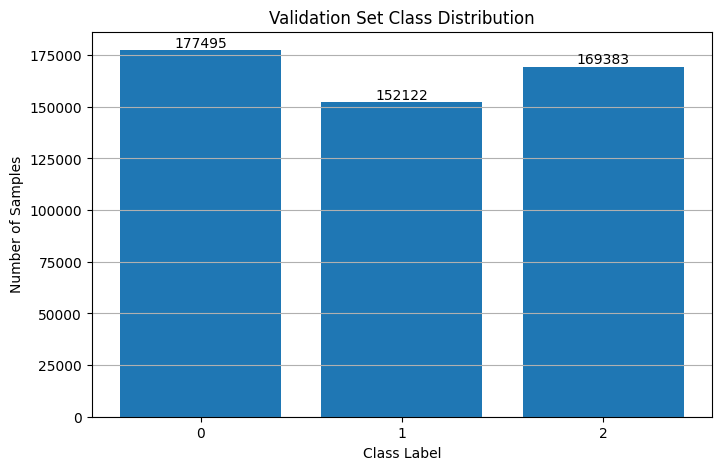

In [9]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Validation Set Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()


In [10]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((499000, 40), (499000,))

In [11]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(498900, 100, 40)

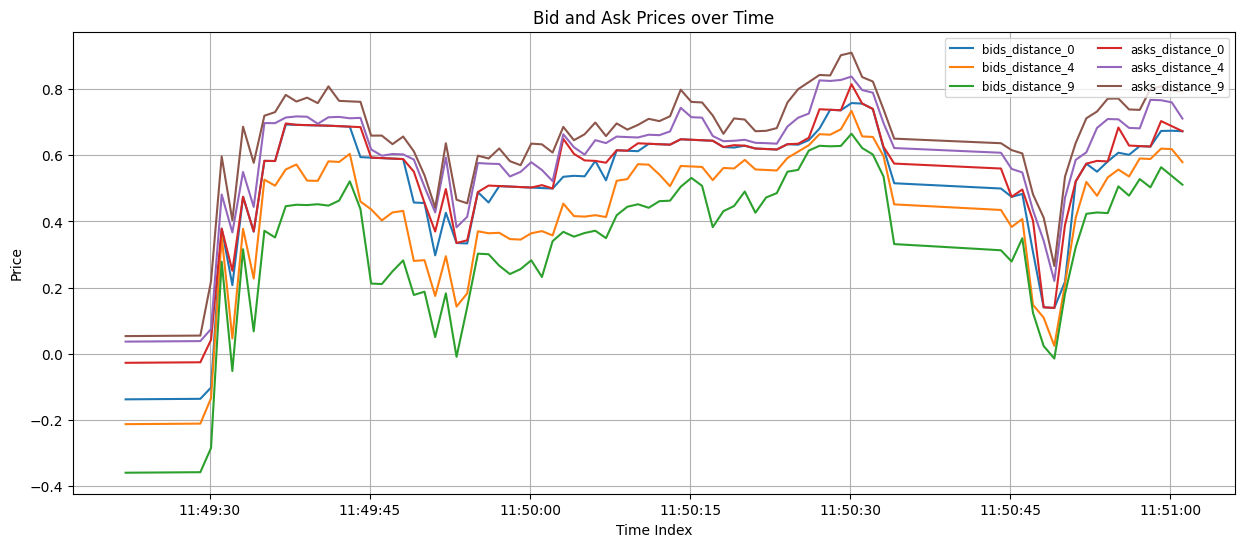

In [12]:
bid_price_cols = ['bids_distance_0','bids_distance_4','bids_distance_9']
ask_price_cols = ['asks_distance_0','asks_distance_4','asks_distance_9']

plot_range = 100

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

In [13]:
# distances = data_df[distance_features].melt(var_name="distance_level", value_name="distance_value")
# notionals = data_df[notional_features].melt(var_name="notional_level", value_name="notional_value")

# combined = pd.DataFrame({
#     "distance": distances["distance_value"],
#     "notional": notionals["notional_value"]
# })

# plt.figure(figsize=(14, 6))
# plt.scatter(combined["distance"], combined["notional"], alpha=0.3)
# plt.xlabel('Distance from Midprice')
# plt.ylabel('Notional Volume')
# plt.title('Price Distance vs Notional Volume')
# plt.grid(True)
# plt.show()

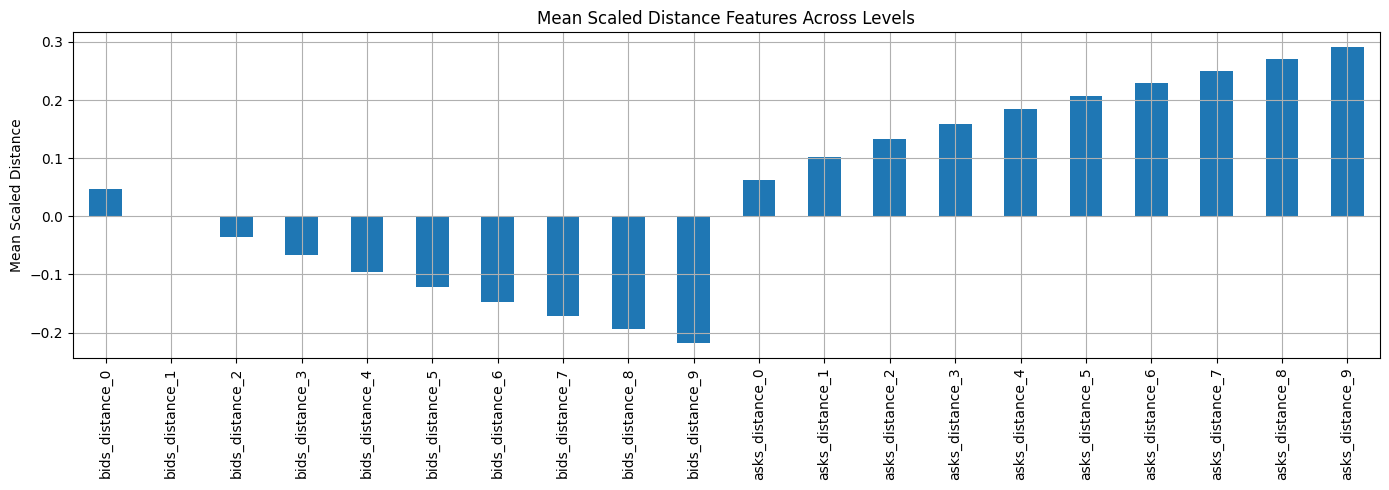

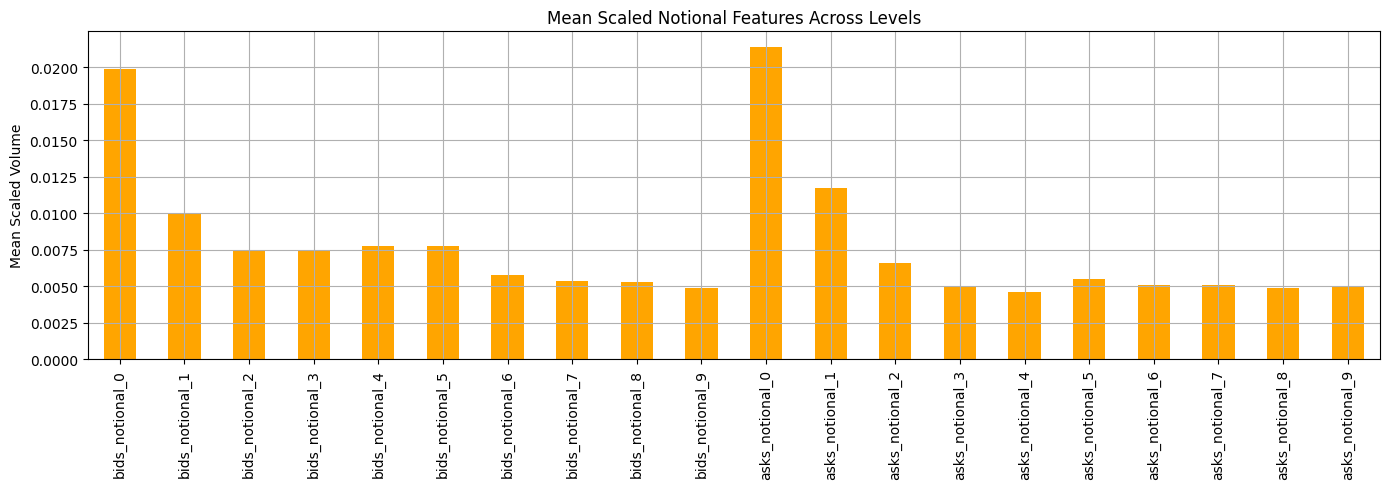

In [13]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
data_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## TransLOB

In [ ]:
train_size = int(0.8 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_test, y_test = X_windows[train_size:], y_labels[train_size:]

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.5, 
    random_state=42, 
    shuffle=True
)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Validation shape: {X_test.shape}, {y_test.shape}")

In [14]:
train_size = int(0.8 * len(X_windows))

X_temp, y_temp = X_windows[:train_size], y_labels[:train_size]
X_test, y_test = X_windows[train_size:], y_labels[train_size:]

In [ ]:
train_dataset = LOBDataset(X_train, y_train)
val_dataset = LOBDataset(X_val, y_val)
test_dataset = LOBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = TransLOB(
    num_features=len(feature_cols),
    num_classes=3,
    hidden_channels=14,
    d_model=64,
    num_heads=4,
    num_transformer_blocks=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 30
best_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './outputs/transLOB/best_model.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

In [ ]:
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        _, y_pred = outputs.max(1)

        all_y_true.append(y_batch.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

all_y_true = np.concatenate(all_y_true)
all_y_pred = np.concatenate(all_y_pred)

cm = confusion_matrix(all_y_true, all_y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Validation Set")
plt.show()